In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import statsmodels.api as sm
import arch
import yfinance as yf

import FinancialMachineLearning as fml

In [2]:
gdp = pd.read_csv('./Data/GDPrate.csv', index_col = 2)
gdp = gdp.Value.astype(float)
gdp.index = pd.date_range(start = '1980-04-01', end = '2022-12-31', freq = 'Q')

unemploy = pd.read_csv('./Data/unemployment.csv', index_col = 2)
unemploy = unemploy.Value.astype(float) * 0.01
unemploy.index = pd.date_range(start = '1953-01-01', end = '2023-03-31', freq = 'M')

interest = pd.read_csv('./Data/interest.csv', index_col = 2)
interest = interest.Value.astype(float) * 0.01
interest.index = pd.to_datetime(interest.index)

inflation = pd.read_csv('./Data/inflation.csv', index_col = 2)
inflation = inflation.Value.astype(float) * 0.01
inflation.index = pd.to_datetime(inflation.index)

In [3]:
interest.index = interest.index.to_period('M')
unemploy.index = unemploy.index.to_period('M')
inflation.index = inflation.index.to_period('M')
gdp.index = gdp.index.to_period('M')

In [4]:
feature_Mat = pd.DataFrame(interest)
feature_Mat.columns = ['interest']
feature_Mat

,interest
DateTime,
1972-10,0.0425
1972-11,0.0425
1972-12,0.0425
1973-01,0.0425
1973-02,0.0425
...,...
2022-12,-0.0010
2023-01,-0.0010
2023-02,-0.0010


In [5]:
feature_Mat = feature_Mat.join(inflation.shift(1).loc['1972-10':], how = 'left')
feature_Mat.columns = ['interest','inflation']
feature_Mat

,interest,inflation
DateTime,,
1972-10,0.0425,0.006
1972-11,0.0425,0.007
1972-12,0.0425,-0.003
1973-01,0.0425,0.007
1973-02,0.0425,0.010
...,...,...
2022-12,-0.0010,0.004
2023-01,-0.0010,0.003
2023-02,-0.0010,0.004


d: 0.05, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.1, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.15000000000000002, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.2, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.25, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.30000000000000004, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.35000000000000003, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.4, error: maxlag must be less than (nobs/2 - 1 - ntrend)

,adfStat,pVal,lags,nObs,95% conf
0.00,-9.234409,1.645206e-15,1.0,635.0,-2.866102
0.75,1.125865,9.954314e-01,1.0,5.0,-3.929280
0.80,-0.915875,7.826997e-01,1.0,10.0,-3.232950
0.85,-1.747602,4.067682e-01,1.0,19.0,-3.031227
0.90,-2.568721,9.963594e-02,1.0,40.0,-2.937069
0.95,-5.081976,1.523728e-05,1.0,99.0,-2.891208
1.00,-13.219524,1.008372e-24,1.0,634.0,-2.866110


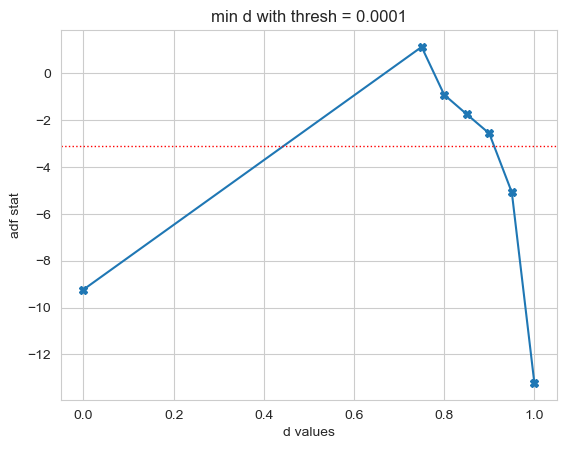

In [6]:
cols = ['adfStat','pVal','lags','nObs','95% conf']
out = pd.DataFrame(columns = cols)
for d in np.linspace(0,1,21):
    try:
        df0 = fml.fracDiff(pd.DataFrame((inflation.cumsum() + 1) * 100), d, thres = 1e-5)
        df0 = sm.tsa.stattools.adfuller(df0, maxlag = 1, regression = 'c', autolag = None)
        out.loc[d] = list(df0[:4]) + [df0[4]['5%']]
    except Exception as e:
        print(f'd: {d}, error: {e}')
        continue

f,ax = plt.subplots()
out['adfStat'].plot(ax = ax, marker = 'X')
ax.axhline(out['95% conf'].mean(), lw = 1, color = 'r', ls = 'dotted')
ax.set_title('min d with thresh = 0.0001')
ax.set_xlabel('d values')
ax.set_ylabel('adf stat');
display(out)

In [7]:
infla_frac = fml.fracDiff_FFD(pd.DataFrame(inflation.shift(1)), 0.95)
infla_frac

,Value
1976-09,-0.011054
1976-10,0.030397
1976-11,-0.017782
1976-12,-0.006369
1977-01,0.011578
...,...
2022-11,0.000062
2022-12,0.000039
2023-01,-0.000969
2023-02,0.000976


In [8]:
feature_Mat = feature_Mat.join(infla_frac.loc['1972-10':], how = 'left')
feature_Mat.columns = ['interest','inflation','inflation_frac']
feature_Mat

,interest,inflation,inflation_frac
1972-10,0.0425,0.006,NaN
1972-11,0.0425,0.007,NaN
1972-12,0.0425,-0.003,NaN
1973-01,0.0425,0.007,NaN
1973-02,0.0425,0.010,NaN
...,...,...,...
2022-12,-0.0010,0.004,0.000039
2023-01,-0.0010,0.003,-0.000969
2023-02,-0.0010,0.004,0.000976
2023-03,-0.0010,-0.006,-0.009954


In [9]:
feature_Mat = feature_Mat.join(unemploy.loc['1972-10-02':], how = 'left')
feature_Mat.columns = ['interest','inflation','inflation_frac','unemployment']
feature_Mat

,interest,inflation,inflation_frac,unemployment
1972-10,0.0425,0.006,NaN,0.014
1972-11,0.0425,0.007,NaN,0.014
1972-12,0.0425,-0.003,NaN,0.014
1973-01,0.0425,0.007,NaN,0.013
1973-02,0.0425,0.010,NaN,0.012
...,...,...,...,...
2022-12,-0.0010,0.004,0.000039,0.025
2023-01,-0.0010,0.003,-0.000969,0.024
2023-02,-0.0010,0.004,0.000976,0.026
2023-03,-0.0010,-0.006,-0.009954,0.028


In [10]:
unemploy_frac = fml.fracDiff_FFD(pd.DataFrame(unemploy), 0.85, thres=1e-5)
unemploy_frac

,Value
1967-05,-0.001108
1967-06,0.000831
1967-07,-0.000935
1967-08,-0.000117
1967-09,-0.001061
...,...
2022-11,-0.000979
2022-12,-0.000137
2023-01,-0.001075
2023-02,0.001800


In [11]:
feature_Mat = feature_Mat.join(unemploy_frac.loc['1972-10':], how = 'left')
feature_Mat.columns = ['interest','inflation','inflation_frac','unemployment','unemployment_frac']
feature_Mat

,interest,inflation,inflation_frac,unemployment,unemployment_frac
1972-10,0.0425,0.006,NaN,0.014,-0.000787
1972-11,0.0425,0.007,NaN,0.014,-0.000004
1972-12,0.0425,-0.003,NaN,0.014,0.000033
1973-01,0.0425,0.007,NaN,0.013,-0.000957
1973-02,0.0425,0.010,NaN,0.012,-0.001104
...,...,...,...,...,...
2022-12,-0.0010,0.004,0.000039,0.025,-0.000137
2023-01,-0.0010,0.003,-0.000969,0.024,-0.001075
2023-02,-0.0010,0.004,0.000976,0.026,0.001800
2023-03,-0.0010,-0.006,-0.009954,0.028,0.002178


In [12]:
stock_code = "^N225"
nikkei = yf.download(stock_code, start="1960-01-01", end="2023-05-31")
nikkei = nikkei['Adj Close'].resample('M').last()
nikkei.index = nikkei.index.to_period('M')
nikkei

[*********************100%***********************]  1 of 1 completed


Date
1965-01     1242.270020
1965-02     1213.069946
1965-03     1132.770020
1965-04     1176.640015
1965-05     1096.599976
               ...     
2023-01    27327.109375
2023-02    27445.560547
2023-03    28041.480469
2023-04    28856.439453
2023-05    30916.310547
Freq: M, Name: Adj Close, Length: 701, dtype: float64

d: 0.05, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.1, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.15000000000000002, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.2, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.25, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.30000000000000004, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.35000000000000003, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.4, error: maxlag must be less than (nobs/2 - 1 - ntrend)

,adfStat,pVal,lags,nObs,95% conf
0.00,-1.060211,7.306759e-01,1.0,698.0,-2.865690
0.75,-1.117378,7.080921e-01,1.0,7.0,-3.477583
0.80,-2.635347,8.590952e-02,1.0,12.0,-3.154972
0.85,-4.665412,9.768610e-05,1.0,23.0,-2.998500
0.90,-5.407528,3.266050e-06,1.0,48.0,-2.923954
0.95,-8.339217,3.209890e-13,1.0,118.0,-2.886363
1.00,-18.515810,2.111728e-30,1.0,697.0,-2.865696


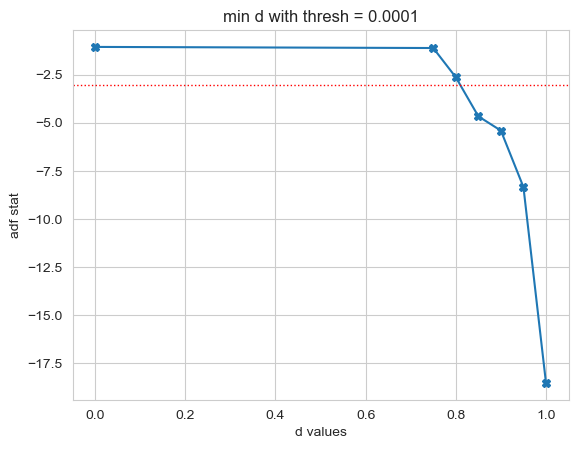

In [13]:
cols = ['adfStat','pVal','lags','nObs','95% conf']
out = pd.DataFrame(columns = cols)
for d in np.linspace(0,1,21):
    try:
        df0 = fml.fracDiff(pd.DataFrame(nikkei), d, thres = 1e-5)
        df0 = sm.tsa.stattools.adfuller(df0, maxlag = 1, regression = 'c', autolag = None)
        out.loc[d] = list(df0[:4]) + [df0[4]['5%']]
    except Exception as e:
        print(f'd: {d}, error: {e}')
        continue

f,ax = plt.subplots()
out['adfStat'].plot(ax = ax, marker = 'X')
ax.axhline(out['95% conf'].mean(), lw = 1, color = 'r', ls = 'dotted')
ax.set_title('min d with thresh = 0.0001')
ax.set_xlabel('d values')
ax.set_ylabel('adf stat');
display(out)

In [14]:
fracdiff = fml.fracDiff_FFD(pd.DataFrame(nikkei), 0.84)
fracdiff

,Adj Close
1980-03,-140.469177
1980-04,336.055375
1980-05,75.220198
1980-06,79.459108
1980-07,8.500310
...,...
2023-01,1118.616433
2023-02,307.308148
2023-03,757.800294
2023-04,1050.522292


In [15]:
feature_Mat = feature_Mat.join(fracdiff, how = 'left').fillna(method = 'bfill')
feature_Mat.columns = ['interest','inflation','inflation_frac','unemployment','unemployment_frac','stock']
feature_Mat

,interest,inflation,inflation_frac,unemployment,unemployment_frac,stock
1972-10,0.0425,0.006,-0.011054,0.014,-0.000787,-140.469177
1972-11,0.0425,0.007,-0.011054,0.014,-0.000004,-140.469177
1972-12,0.0425,-0.003,-0.011054,0.014,0.000033,-140.469177
1973-01,0.0425,0.007,-0.011054,0.013,-0.000957,-140.469177
1973-02,0.0425,0.010,-0.011054,0.012,-0.001104,-140.469177
...,...,...,...,...,...,...
2022-12,-0.0010,0.004,0.000039,0.025,-0.000137,-1641.777084
2023-01,-0.0010,0.003,-0.000969,0.024,-0.001075,1118.616433
2023-02,-0.0010,0.004,0.000976,0.026,0.001800,307.308148
2023-03,-0.0010,-0.006,-0.009954,0.028,0.002178,757.800294


In [16]:
stock_code = "^N225"
nikkei_d = yf.download(stock_code, start="1960-01-01", end="2023-05-31")
nikkei_d = nikkei_d['Adj Close']
nikkei_d.index = nikkei_d.index.to_period('D')
nikkei_d

[*********************100%***********************]  1 of 1 completed


Date
1965-01-05     1257.719971
1965-01-06     1263.989990
1965-01-07     1274.270020
1965-01-08     1286.430054
1965-01-12     1288.540039
                  ...     
2023-05-22    31086.820312
2023-05-23    30957.769531
2023-05-24    30682.679688
2023-05-25    30801.130859
2023-05-26    30916.310547
Freq: D, Name: Adj Close, Length: 14359, dtype: float64

In [17]:
fracstock = fml.fracDiff_FFD(pd.DataFrame(nikkei_d), 0.55)
fracstock

,Adj Close
1968-01-11,33.090310
1968-01-12,21.709528
1968-01-16,20.788780
1968-01-17,19.313263
1968-01-18,26.444986
...,...
2023-05-22,1290.438640
2023-05-23,922.658447
2023-05-24,631.044349
2023-05-25,862.057086


In [18]:
dailyVol = fml.getDailyVolatility(fracstock['Adj Close'], span = 100)
dailyVol

1968-01-16         NaN
1968-01-17    0.048059
1968-01-18    0.205195
1968-01-19    0.287270
1968-01-22    0.252244
                ...   
2023-05-22    6.207321
2023-05-23    6.145633
2023-05-24    6.084841
2023-05-25    6.024295
2023-05-26    5.964755
Freq: D, Name: dailyVol, Length: 13618, dtype: float64

<AxesSubplot:>

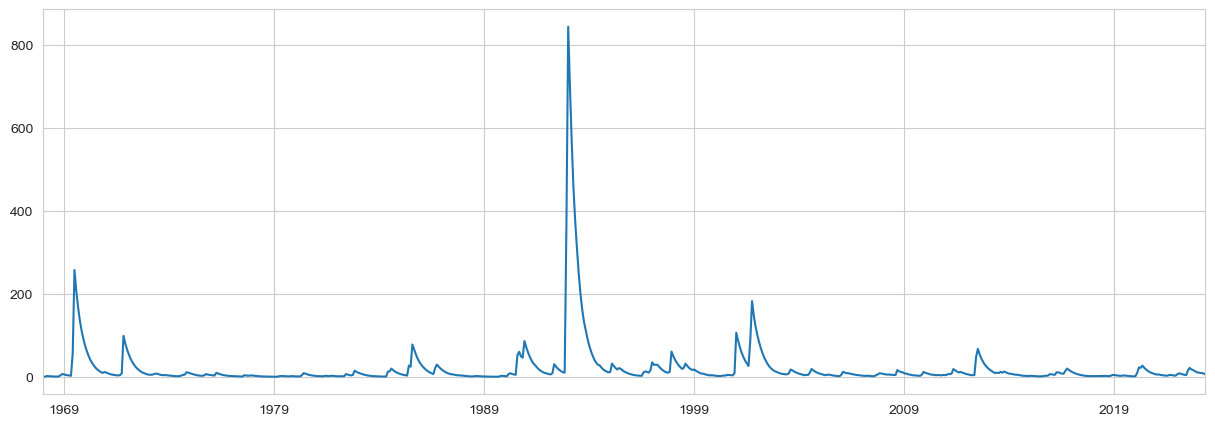

In [19]:
monVol = dailyVol.resample('M').mean()
monVol.plot(figsize = (15,5))

In [20]:
feature_Mat = feature_Mat.join(monVol, how = 'left')
feature_Mat.columns = ['interest','inflation','inflation_frac','unemployment','unemployment_frac','stock','volatility']
feature_Mat

,interest,inflation,inflation_frac,unemployment,unemployment_frac,stock,volatility
1972-10,0.0425,0.006,-0.011054,0.014,-0.000787,-140.469177,10.313719
1972-11,0.0425,0.007,-0.011054,0.014,-0.000004,-140.469177,8.493282
1972-12,0.0425,-0.003,-0.011054,0.014,0.000033,-140.469177,6.924017
1973-01,0.0425,0.007,-0.011054,0.013,-0.000957,-140.469177,5.696488
1973-02,0.0425,0.010,-0.011054,0.012,-0.001104,-140.469177,5.155170
...,...,...,...,...,...,...,...
2022-12,-0.0010,0.004,0.000039,0.025,-0.000137,-1641.777084,11.380976
2023-01,-0.0010,0.003,-0.000969,0.024,-0.001075,1118.616433,10.313131
2023-02,-0.0010,0.004,0.000976,0.026,0.001800,307.308148,9.467592
2023-03,-0.0010,-0.006,-0.009954,0.028,0.002178,757.800294,9.334739


In [21]:
feature_Mat = feature_Mat.join(np.log(nikkei), how = 'left')
feature_Mat.columns = ['interest','inflation','inflation_frac','unemployment','unemployment_frac','frac_stock','volatility','log_stock']
feature_Mat

,interest,inflation,inflation_frac,unemployment,unemployment_frac,frac_stock,volatility,log_stock
1972-10,0.0425,0.006,-0.011054,0.014,-0.000787,-140.469177,10.313719,8.420240
1972-11,0.0425,0.007,-0.011054,0.014,-0.000004,-140.469177,8.493282,8.490636
1972-12,0.0425,-0.003,-0.011054,0.014,0.000033,-140.469177,6.924017,8.557940
1973-01,0.0425,0.007,-0.011054,0.013,-0.000957,-140.469177,5.696488,8.549707
1973-02,0.0425,0.010,-0.011054,0.012,-0.001104,-140.469177,5.155170,8.541167
...,...,...,...,...,...,...,...,...
2022-12,-0.0010,0.004,0.000039,0.025,-0.000137,-1641.777084,11.380976,10.169480
2023-01,-0.0010,0.003,-0.000969,0.024,-0.001075,1118.616433,10.313131,10.215635
2023-02,-0.0010,0.004,0.000976,0.026,0.001800,307.308148,9.467592,10.219960
2023-03,-0.0010,-0.006,-0.009954,0.028,0.002178,757.800294,9.334739,10.241440


In [22]:
feature_Mat = feature_Mat.join(gdp * 0.01, how = 'left').fillna(method = 'bfill')
feature_Mat.columns = ['interest','inflation','inflation_frac','unemployment','unemployment_frac','frac_stock','volatility','log_stock', 'gdp_rate']
feature_Mat

,interest,inflation,inflation_frac,unemployment,unemployment_frac,frac_stock,volatility,log_stock,gdp_rate
1972-10,0.0425,0.006,-0.011054,0.014,-0.000787,-140.469177,10.313719,8.420240,-0.005
1972-11,0.0425,0.007,-0.011054,0.014,-0.000004,-140.469177,8.493282,8.490636,-0.005
1972-12,0.0425,-0.003,-0.011054,0.014,0.000033,-140.469177,6.924017,8.557940,-0.005
1973-01,0.0425,0.007,-0.011054,0.013,-0.000957,-140.469177,5.696488,8.549707,-0.005
1973-02,0.0425,0.010,-0.011054,0.012,-0.001104,-140.469177,5.155170,8.541167,-0.005
...,...,...,...,...,...,...,...,...,...
2022-12,-0.0010,0.004,0.000039,0.025,-0.000137,-1641.777084,11.380976,10.169480,0.000
2023-01,-0.0010,0.003,-0.000969,0.024,-0.001075,1118.616433,10.313131,10.215635,NaN
2023-02,-0.0010,0.004,0.000976,0.026,0.001800,307.308148,9.467592,10.219960,NaN
2023-03,-0.0010,-0.006,-0.009954,0.028,0.002178,757.800294,9.334739,10.241440,NaN


<AxesSubplot:>

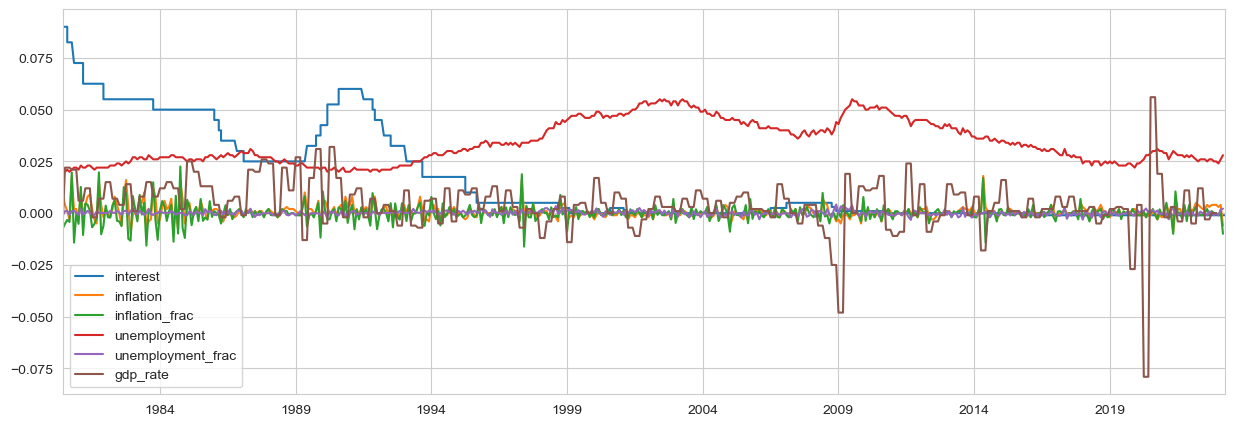

In [23]:
feature_Mat.loc['1980-06':].iloc[:,[0,1,2,3,4,8]].plot(figsize = (15,5))

<AxesSubplot:>

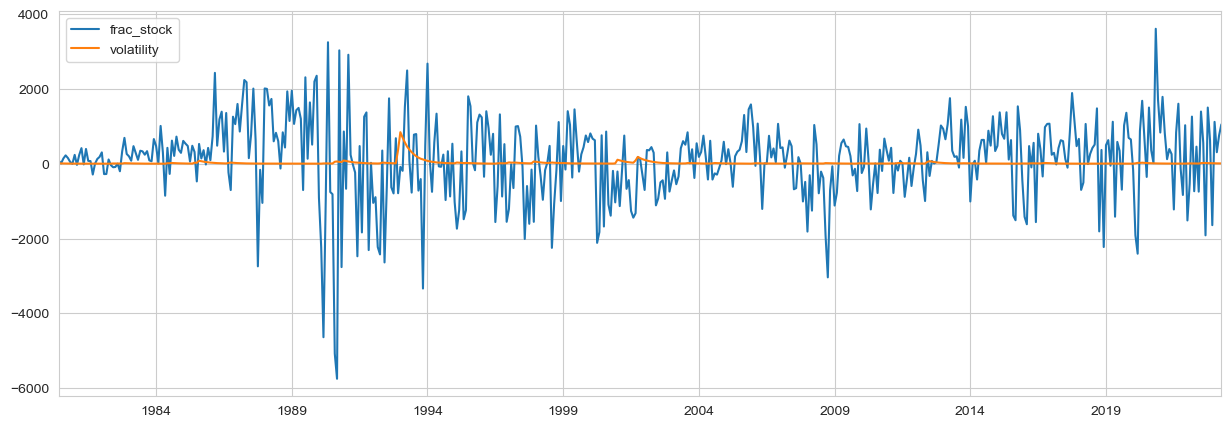

In [24]:
feature_Mat.loc['1980-06':].iloc[:,[5,6]].plot(figsize = (15,5))

In [25]:
Data = feature_Mat.loc['1980-06':'2022-12']

In [26]:
Data

,interest,inflation,inflation_frac,unemployment,unemployment_frac,frac_stock,volatility,log_stock,gdp_rate
1980-06,0.0900,0.009,-0.007441,0.019,-0.000926,79.459108,9.278598,8.835021,-0.005
1980-07,0.0900,0.004,-0.005100,0.020,0.000909,8.500310,7.506639,8.827560,0.022
1980-08,0.0900,0.001,-0.003251,0.021,0.001117,140.303187,6.046777,8.841315,0.022
1980-08,0.0825,0.001,-0.003251,0.021,0.001117,140.303187,6.046777,8.841315,0.022
1980-09,0.0825,-0.003,-0.004262,0.020,-0.000775,223.132931,4.933045,8.864529,0.022
...,...,...,...,...,...,...,...,...,...
2022-08,-0.0010,0.004,0.001989,0.025,-0.001016,557.424146,21.613584,10.243223,-0.003
2022-09,-0.0010,0.003,-0.000903,0.026,0.000838,-1913.740073,18.013554,10.163434,-0.003
2022-10,-0.0010,0.004,0.001004,0.026,0.000056,1501.135299,16.257009,10.225117,0.000
2022-11,-0.0010,0.004,0.000062,0.025,-0.000979,620.502249,13.888344,10.238852,0.000


In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

X = Data.iloc[:,:-2]
y = Data['gdp_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = False)

model = RandomForestRegressor(n_estimators = 10000,
                              random_state = 42,
                              criterion = 'mae',
                              bootstrap = False)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Test MSE: {mse:.3f}')
print(f'Test MSE: {mae:.3f}')

Test MSE: 0.000
Test MSE: 0.015


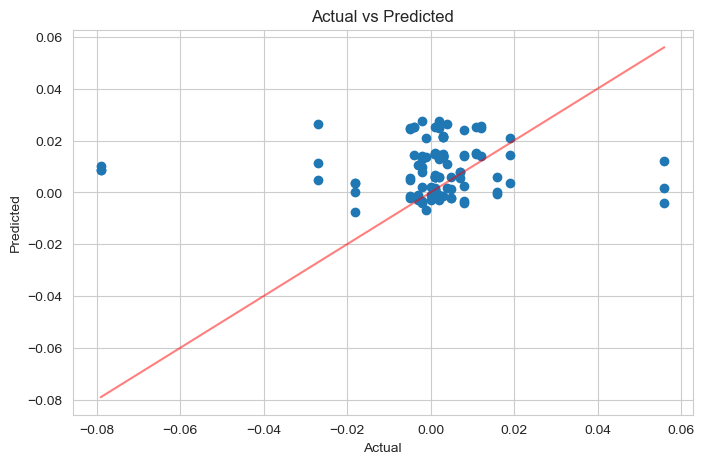

In [28]:
predictions = model.predict(X_test)
plt.figure(figsize=(8, 5))
plt.scatter(y_test, predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'red', alpha = 0.5)
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [29]:
y_test.shape

(110,)

In [30]:
yt = pd.DataFrame(y_test, index = Data.index[-110:])
pred_y = pd.DataFrame(predictions, index = Data.index[-110:])
ytrain = pd.DataFrame(y_train, index = Data.index[:-110])

In [31]:
yt.index = yt.index.to_timestamp()
pred_y.index = pred_y.index.to_timestamp()
ytrain.index = ytrain.index.to_timestamp()

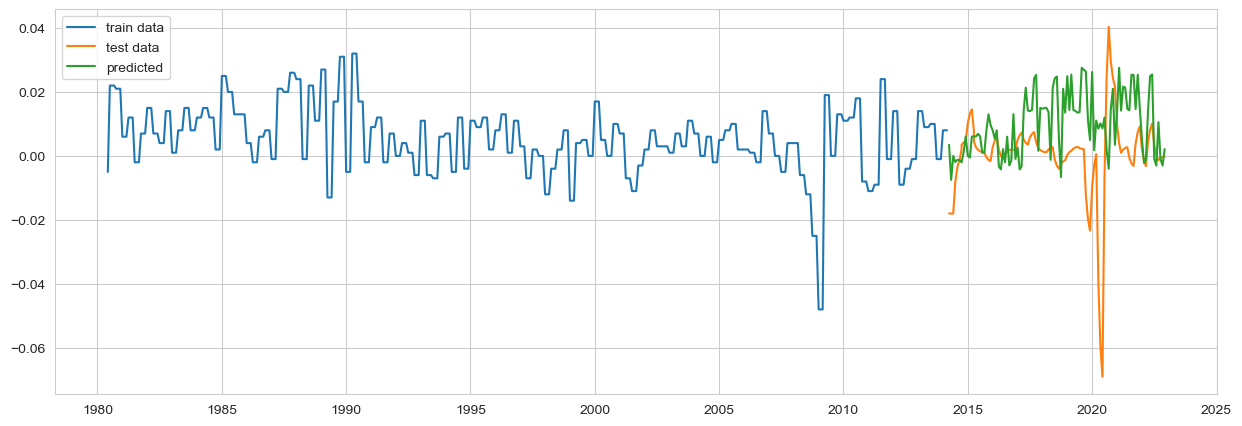

In [32]:
plt.figure(figsize=(15,5))
plt.plot(ytrain, label = 'train data')
plt.plot(yt.ewm(span=3).mean(), label = 'test data')
plt.plot(pred_y, label = 'predicted')
plt.legend()
plt.show()

statsmodels

In [33]:
import statsmodels.api as sm
y = Data['gdp_rate']
X = Data.drop(['gdp_rate'], axis = 1)
X = sm.add_constant(X)

fitmodel = sm.OLS(y, X)
results = fitmodel.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               gdp_rate   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     11.27
Date:                Sun, 28 May 2023   Prob (F-statistic):           8.48e-15
Time:                        03:33:39   Log-Likelihood:                 1647.0
No. Observations:                 546   AIC:                            -3276.
Df Residuals:                     537   BIC:                            -3237.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.1008      0.020     -4.961      0.000      -0.141      -0.061
interest              0.3215      0.039      8.174      0.000       0.244       0.399
inflation            -0.2370      0.239     -0.993      0.321      -0.706       0.232
inflation_frac        0.1281      0.174      0.736      0.462      -0.214       0.470
unemployment          0.4218      0.096      4.397      0.000       0.233       0.610
unemployment_frac    -1.2927      0.482     -2.680      0.008      -2.240      -0.345
frac_stock         9.961e-07   4.67e-07      2.131      0.034     7.8e-08    1.91e-06
volatility        -1.052e-05   7.87e-06     -1.337      0.182    -2.6e-05    4.93e-06
log_stock             0.0089      0.002      4.925      0.000       0.005       0.012
==============================================================================
Omnibus:                      219.486   Durbin-Watson:                   0.810
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3447.567
Skew:                          -1.328   Prob(JB):                         0.00
Kurtosis:                      15.020   Cond. No.                     1.05e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5, 1.0, 'Residual vs. Normal')

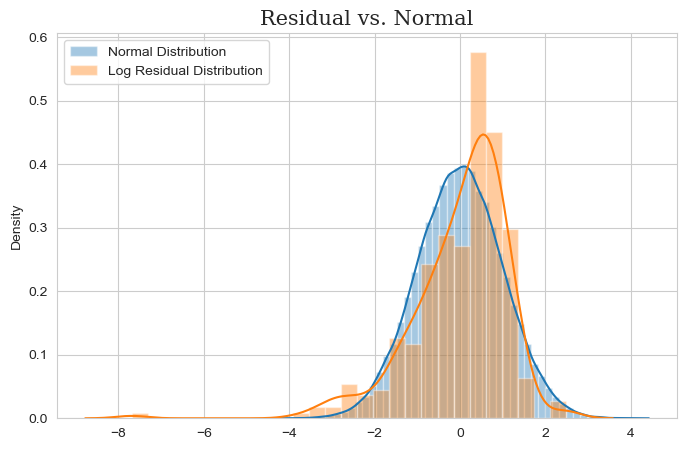

In [34]:
fig, ax1 = plt.subplots(figsize=(8,5), dpi=100)
sns.distplot(np.random.normal(size=100000), kde = True, ax = ax1, label = 'Normal Distribution')
sns.distplot(np.log(results.resid) - np.log(results.resid).mean() ,
             kde = True, rug = False , ax = ax1, label = 'Log Residual Distribution')
plt.legend()
plt.title('Residual vs. Normal', fontsize = 15, fontfamily = 'Serif')

Text(0, 0.5, 'predicted GDP rate')

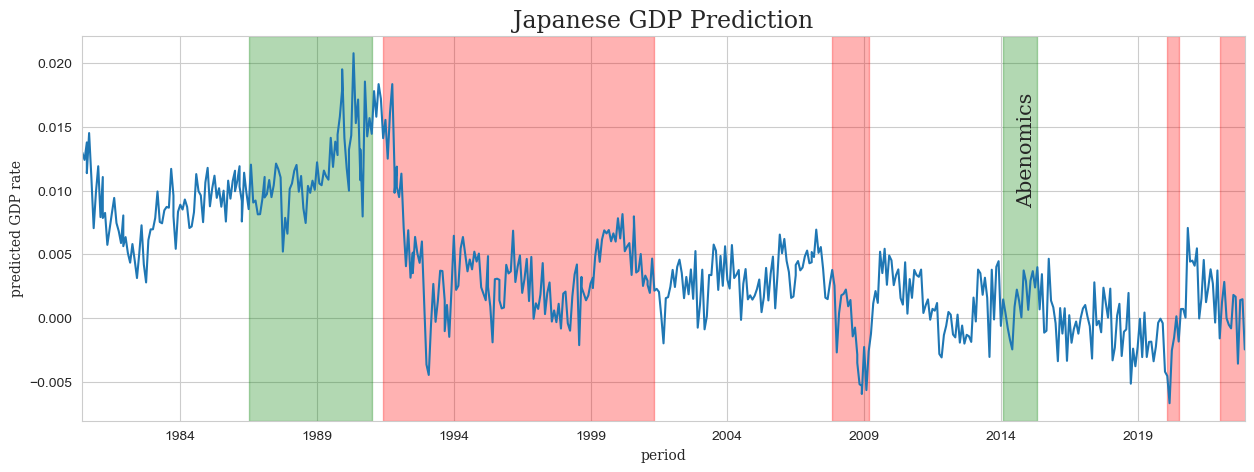

In [35]:
results.fittedvalues.plot(figsize = (15,5))
plt.axvspan('1991-06-01', '2001-05-31', color = 'red', alpha = 0.3)
plt.axvspan('2007-11-01', '2009-03-31', color = 'red', alpha = 0.3)
plt.axvspan('2014-02-01', '2015-05-31', color = 'green', alpha = 0.3)
plt.axvspan('1986-07-01', '1991-01-31', color = 'green', alpha = 0.3)
plt.axvspan('2020-02-01', '2020-07-31', color = 'red', alpha = 0.3)
plt.axvspan('2022-01-01', '2023-04-30', color = 'red', alpha = 0.3)
plt.text(535, 0.009, 'Abenomics', ha = 'left', fontsize = 15, fontfamily = 'Serif', rotation = 90)
plt.title('Japanese GDP Prediction', fontfamily = 'Serif', fontsize = 17)
plt.xlabel('period', fontfamily = 'Serif', fontsize = 10)
plt.ylabel('predicted GDP rate', fontfamily = 'Serif', fontsize = 10)

#### Prediction

In [36]:
feature_Mat.tail(10)

,interest,inflation,inflation_frac,unemployment,unemployment_frac,frac_stock,volatility,log_stock,gdp_rate
2022-07,-0.001,0.002,-0.000038,0.026,-0.000018,1394.504182,15.915805,10.232850,-0.003
2022-08,-0.001,0.004,0.001989,0.025,-0.001016,557.424146,21.613584,10.243223,-0.003
2022-09,-0.001,0.003,-0.000903,0.026,0.000838,-1913.740073,18.013554,10.163434,-0.003
2022-10,-0.001,0.004,0.001004,0.026,0.000056,1501.135299,16.257009,10.225117,0.000
2022-11,-0.001,0.004,0.000062,0.025,-0.000979,620.502249,13.888344,10.238852,0.000
2022-12,-0.001,0.004,0.000039,0.025,-0.000137,-1641.777084,11.380976,10.169480,0.000
2023-01,-0.001,0.003,-0.000969,0.024,-0.001075,1118.616433,10.313131,10.215635,NaN
2023-02,-0.001,0.004,0.000976,0.026,0.001800,307.308148,9.467592,10.219960,NaN
2023-03,-0.001,-0.006,-0.009954,0.028,0.002178,757.800294,9.334739,10.241440,NaN
2023-04,-0.001,NaN,NaN,NaN,NaN,1050.522292,7.778409,10.270088,NaN


In [38]:
model.predict(feature_Mat.loc['2023-01':'2023-03'].iloc[:,:-2]).mean()

0.005650866666666415